In [1]:
import numpy as np
import keras
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, BatchNormalization, Activation, UpSampling2D, Conv2D, LeakyReLU, AveragePooling2D, Flatten,Reshape,Conv2DTranspose, ReLU
from keras.optimizers import RMSprop
from keras.initializers import RandomNormal

from keras.utils import generic_utils, np_utils
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from PIL import Image
import time
import math
from keras import layers
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import keras_tuner as kt

In [2]:
#import datasets
#define datatsets
def load_capacitive_data(dirname = r"../../Milk/DeepPrint2/Verifinger/"):     # change this path to match your own
    import os
    imgs_names = os.listdir(dirname)
    
    #Prep Images
    X = []
    Y = []
    with tqdm(total=len(imgs_names)) as pbar:
        for i in imgs_names:
            if(i.endswith('.BMP')):
                im = Image.open(dirname + i)
                im = im.crop((8, 8, 136, 136))
                im = im.convert('L')
                im = img_to_array(im)
                im = (255 - im) / 255.0    #normalize [0,1]
                #im = (127.5-im) / 127.5   #normalize [-1,1]


                Y.append(i)
                X.append(im)
            pbar.update(1)
    
    X_train = np.array(X)
    Y_train = np.array(Y)
    
    return X_train, Y_train

def load_optical_data(dirname = "optical/"):   # change this path to match your own
    imgs_names = os.listdir(dirname)
    
    #Prep Images
    X = []
    Y = []
    with tqdm(total=len(imgs_names)) as pbar:
        for i in imgs_names:
            if(i.endswith('.tif')):
                im = Image.open(dirname + i)
                im = im.convert('L')
                im = img_to_array(im)
                im = (255 - im) / 255.0    #normalize [0,1]
                #im = (127.5-im) / 127.5   #normalize [-1,1]

                Y.append(i)
                X.append(im)
            pbar.update(1)
    
    X_train = np.array(X)
    Y_train = np.array(Y)
    
    return X_train, Y_train

def load_nist_data(s = 256, dirname = "nist/Right Thumbs/", randcrop=True, rcs=128):   # change this path to match your own
    imgs_names = os.listdir(dirname)
    
    #Prep Images
    X = []
    Y = []
    with tqdm(total=len(imgs_names)) as pbar:
        for i in imgs_names:
            im = Image.open(dirname + i)
            if(im.size[0] >= s and im.size[1] > s):
                Y.append(i)
                xi = resize(im,s)
                if randcrop:
                    xi = random_crop(np.expand_dims(xi,axis=0),rcs)[0]
                X.append(xi)
            pbar.update(1)
    
    X_train = np.array(X)
    Y_train = np.array(Y)
    
    return X_train, Y_train

def random_crop(img,crop_size):
    x, y = (np.random.randint(0, img.shape[1] - crop_size) for i in range(2))
    return img[:, x:x + crop_size, y:y + crop_size]

#resize
def resize(img, s):
    if(img.size[0] > img.size[1]):
        h = s
        ratio = h/float(img.size[1])
        w = int(img.size[0]*ratio)
        img = img.resize((w,h), Image.ANTIALIAS)
        
        border = int((w - s)/2)
        img = img.crop((border, 0, border + s, h))
    else:
        w = s
        ratio = w/float(img.size[0])
        h = int(img.size[1]*ratio)
        img = img.resize((w,h), Image.ANTIALIAS)
        
        border = int((h - s)/2)
        img = img.crop((0, border, w, border + s))
        
    img = img.convert('L')    
    #img = preK.img_to_array(img, 'tf')
    img = img_to_array(img)
    img = (255 - img) / 255.0    #normalize [0,1]
    #img = (127.5-img) / 127.5   #normalize [-1,1]
    
    return img

In [3]:
X_train = []
y_train = []

DATASET = "CAPACITIVE"


if DATASET == "CAPACITIVE":
    X_train, y_train = load_capacitive_data()
elif DATASET == "OPTICAL":
    X_train, y_train = load_optical_data()
elif DATASET == "NIST":
    X_train, y_train = load_nist_data()

#verify shape and datapoints
print(X_train[0].shape)
print(f"[{np.amin(X_train[:10])},{np.amax(X_train[:10])}]")

100%|██████████| 8640/8640 [00:02<00:00, 3002.17it/s]


(128, 128, 1)
[0.0,1.0]


In [4]:
class PrintBinaryCNNMultiClass():
    def __init__(self,classes):
        self.classes = classes
        
        #define model
        self.model = keras.Sequential([
            
            #first layer
            Conv2D(32,(3,3),strides=(2,2) ,activation='elu',input_shape=(128,128,1)),
            layers.MaxPooling2D((2,2)),
            
            layers.Dropout(.1),
            
            #second layer
            layers.Conv2D(64,(3,3),activation='elu'),
            layers.MaxPooling2D((2,2)),
            
            
            #third layer
            layers.Conv2D(128,(3,3),activation='elu'),
            layers.MaxPooling2D((2,2)),
            
            layers.Dropout(.05),
        
            #fourth layer
            layers.Conv2D(256,(3,3),activation='elu'),
            layers.MaxPooling2D((2,2)),
            
            layers.Dropout(.05),
            
            #fifth layer
            #layers.Conv2D(512,(3,3),activation='elu'),
            #layers.MaxPooling2D((2,2)),
            
            #eval layer
            layers.Flatten(),
            layers.Dense(512, activation='elu'),
            layers.Dense(self.classes, activation='sigmoid')       #sigmoid is confidence in label
        ])
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
        self.model.summary()

    def train(self,X,y,EPOCHS=25,BATCH_SIZE=16,val_dat=None):
        print("-- TRAINING MULTI-CLASSIFIER on [ %d ] LABELS --" % (self.classes))
        #with tf.device('/device:GPU:2'):
        with tf.device('/device:CPU:0'):
            self.model.fit(X, y, epochs=EPOCHS,shuffle=True,batch_size=BATCH_SIZE,validation_data=val_dat)

    #returns the confidence score for a set of numbers (1 = is number it was trained on, 0 = number not trained on)
    def predict(self, imgs):
        p = self.model.predict(imgs)
        return p
    
    def exportModel(self,name=''):
        self.model.save(f"print_multiclassifier_{name}.h5")
        
    def importModel(self,name=''):
        self.model = keras.models.load_model(f"print_multiclassifier_{name}.h5")

In [5]:
y_clean = list(map(lambda x: int(x.split("_")[1])-1,y_train))

In [6]:
print_dict = {}
for i in range(len(X_train)):
    if y_clean[i] not in print_dict:
        print_dict[y_clean[i]] = []
    print_dict[y_clean[i]].append(X_train[i])

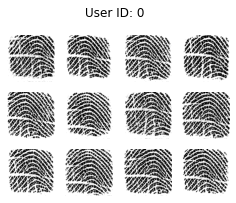

In [7]:
import random
#user_id = random.randint(0,720)
user_id = 0

fig = plt.figure(figsize=(4, 4))
fig.suptitle(f"User ID: {user_id}")

for i in range(len(print_dict[user_id])):
    plt.subplot(4, 4, i+1)
    plt.imshow(print_dict[user_id][i], cmap='binary')
    plt.axis('off')

plt.show()

### Train MC on hand-picked subset of IDS

In [8]:
import cv2

#image augmentation functions
def crop_to_center(old_img, new_img):
    """
    Crops `new_img` to `old_img` dimensions
    :param old_img: <numpy.ndarray> or <tuple> dimensions
    :param new_img: <numpy.ndarray>
    :return: <numpy.ndarray> new image cropped to old image dimensions
    """

    if isinstance(old_img, tuple):
        original_shape = old_img
    else:
        original_shape = old_img.shape
    original_width = original_shape[1]
    original_height = original_shape[0]
    original_center_x = original_shape[1] / 2
    original_center_y = original_shape[0] / 2

    new_width = new_img.shape[1]
    new_height = new_img.shape[0]
    new_center_x = new_img.shape[1] / 2
    new_center_y = new_img.shape[0] / 2

    new_left_x = int(max(new_center_x - original_width / 2, 0))
    new_right_x = int(min(new_center_x + original_width / 2, new_width))
    new_top_y = int(max(new_center_y - original_height / 2, 0))
    new_bottom_y = int(min(new_center_y + original_height / 2, new_height))

    # create new img canvas
    canvas = np.zeros(original_shape)

    left_x = int(max(original_center_x - new_width / 2, 0))
    right_x = int(min(original_center_x + new_width / 2, original_width))
    top_y = int(max(original_center_y - new_height / 2, 0))
    bottom_y = int(min(original_center_y + new_height / 2, original_height))

    canvas[top_y:bottom_y, left_x:right_x] = new_img[new_top_y:new_bottom_y, new_left_x:new_right_x]

    return canvas

def rotate_image(image, angle):
    """Rotate the image counterclockwise.
    Rotate the image such that the rotated image is enclosed inside the
    tightest rectangle. The area not occupied by the pixels of the original
    image is colored black.
    Parameters
    ----------
    image : numpy.ndarray
        numpy image
    angle : float
        angle by which the image is to be rotated. Positive angle is
        counterclockwise.
    Returns
    -------
    numpy.ndarray
        Rotated Image
    """
    # get dims, find center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    image = cv2.warpAffine(image, M, (nW, nH))

    # image = cv2.resize(image, (w,h))

    return image

def shift_image(image, amt, direction):
    original_shape = image.shape
        
    # create new img canvas
    canvas = np.zeros(original_shape[:2])

    if direction == "top":
        canvas[0:original_shape[0]-amt, :] = image[amt:, :].squeeze()
    elif direction == "bottom":
        canvas[amt:original_shape[0], :] = image[:original_shape[0]-amt, :].squeeze()
    elif direction == "left":
        canvas[:, 0:original_shape[1]-amt] = image[:, amt:].squeeze()
    elif direction == "right":
        canvas[:, amt:original_shape[1]] = image[:, :original_shape[1]-amt].squeeze()

    return canvas

In [9]:
#SEL_IDS = np.random.choice(range(720),10)                    #random 10 users from entire CAP dataset
#SEL_IDS = [23, 694, 704, 622, 55, 30, 608, 107, 164, 29]     #1 from each cluster (hand picked)

SEL_IDS = list(range(720))#10 from one cluster (hand picked)
random.shuffle(SEL_IDS)
num_ids = len(SEL_IDS)

fig = plt.figure(figsize=(4, 4))
fig.suptitle(f"IDs: {SEL_IDS}")

i=0
'''for si in SEL_IDS:
    plt.subplot(4, 4, i+1)
    g = print_dict[si]
    j = random.randint(0,len(g)-1)
    plt.imshow(g[j], cmap='binary')
    plt.axis('off')
    i+=1'''
    
    
#make a set of the groups
sm_x_train = []
sm_y_train = []
aug = 5
bad = 0
for si in SEL_IDS:
    #vanilla
    sm_x_train += print_dict[si]
    sm_y_train += [si]*len(print_dict[si])
    
    #bad examples
    for b in range(bad):
        r = random.randint(0,720)
        while r in SEL_IDS:
            r = random.randint(0,720)
        sm_x_train += print_dict[r]
        sm_y_train += [-1]*len(print_dict[si])
        
    #augmentations (shift)
    aug_set = []
    for im in print_dict[si]:
        for a in range(aug):
            aug_im = shift_image(np.array(im),random.randint(1,10),random.choice(['top','bottom','left','right']))
            aug_im = np.expand_dims(np.array(aug_im),axis=2)
            aug_set.append(aug_im)
    
    #augmentations (rotation)
    for im in print_dict[si]:
        for a in range(aug):
            aug_im = crop_to_center(im.squeeze(), rotate_image(im.squeeze(), random.randint(-20,20)))
            aug_im = np.expand_dims(np.array(aug_im),axis=2)
            aug_set.append(aug_im)
    sm_x_train += aug_set
    sm_y_train += ([si]*(len(print_dict[si])*aug*2))
    
sm_x_train = np.array(sm_x_train)
sm_y_train = np.array(sm_y_train)

print(sm_x_train.shape)
print(sm_y_train.shape)

#sm_x_train = sm_x_train.reshape((sm_x_train.shape[0]*sm_x_train.shape[1],128,128,1))
sm_y_train = sm_y_train.reshape((np.prod(sm_y_train.shape)))
oneh = []
for y in sm_y_train:
    a = np.zeros(num_ids)
    if y != -1:
        a[y] = 1
    oneh.append(a)
oneh = np.array(oneh)

print(sm_x_train.shape)
print(oneh.shape)
print(sm_y_train[0])  #same as below
print(oneh[0])        
print(np.where(oneh[0]==1.0)[0])  #same as above

(95040, 128, 128, 1)
(95040,)
(95040, 128, 128, 1)
(95040, 720)
470
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

<Figure size 288x288 with 0 Axes>

In [10]:
print(np.unique(sm_y_train))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [11]:
print(y_clean.index(0))
print(y_train[213])

213
AES3400_0001_01.BMP


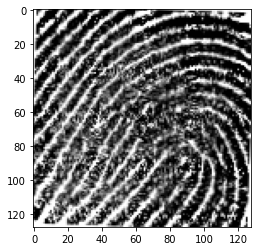

In [12]:
plt.imshow(crop_to_center(X_train[0].squeeze(), rotate_image(X_train[0].squeeze(), random.randint(-20,0))),cmap='binary')

In [20]:
#split to train and test
test_perc = 0.1

te_set = np.random.choice(list(range(len(sm_x_train))),int(test_perc*len(sm_x_train)))
tr_set = [x for x in list(range(len(sm_x_train))) if x not in te_set]

train_dat_x = sm_x_train[tr_set]
train_dat_y = oneh[tr_set]
val_dat_x = sm_x_train[te_set]
val_dat_y = oneh[te_set]


print(f"TRAIN: {len(train_dat_x)}")
print(f"VAL: {len(val_dat_x)}")

TRAIN: 86001
VAL: 9504


In [21]:
print(num_ids)
print(train_dat_x.shape, train_dat_y.shape)
print(val_dat_x.shape, val_dat_y.shape)

720
(86001, 128, 128, 1) (86001, 720)
(9504, 128, 128, 1) (9504, 720)


In [22]:
printMC = PrintBinaryCNNMultiClass(num_ids)
#changed from 100 epochs (converged at 20 epochs)
printMC.train(train_dat_x,train_dat_y,20,32,(val_dat_x,val_dat_y))    


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 63, 63, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 128)        

In [16]:
printMC.exportModel("720")

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

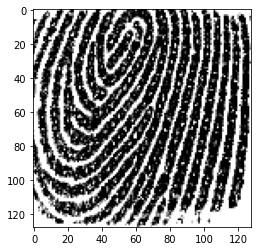

In [18]:
#predict
testprint_x = train_dat_x[0]
testprint_y = train_dat_y[0]

plt.imshow(testprint_x.squeeze(), cmap='binary')
print(testprint_y)

print(printMC.predict(np.expand_dims(testprint_x,axis=0)))


In [19]:
#accuracy analysis
n = 100
# rand_set = random.choices(list(range(len(train_dat_x))),k=n)
# tx = train_dat_x[rand_set]
# ty = train_dat_y[rand_set]

rand_set = random.choices(list(range(len(X_train))),k=n)
tx = X_train[rand_set]
ty = [y_clean[i] for i in rand_set]

correct = 0
for i in range(n):
    p = printMC.predict(np.expand_dims(tx[i],axis=0))[0].round(2)
    pi = np.where(p==1.0)[0]
    #tyi = np.where(ty[i]==1.0)[0]
    tyi = ty[i]
    print(f"{pi} -- {tyi}")
    if tyi in pi:
        correct += 1
print(f"Correct predictions: {correct/n}")

[] -- 331
[368] -- 368
[348] -- 348
[576] -- 576
[475] -- 475
[328] -- 328
[638] -- 638
[261] -- 261
[114] -- 114
[376] -- 376
[669] -- 669
[577] -- 577
[157] -- 157
[235] -- 235
[686] -- 686
[476] -- 476
[583] -- 583
[363] -- 363
[563] -- 563
[641] -- 641
[250] -- 250
[314] -- 314
[154] -- 154
[707] -- 707
[450] -- 450
[381] -- 381
[357] -- 357
[568] -- 568
[373] -- 373
[28] -- 28
[446] -- 446
[390] -- 390
[694] -- 694
[336] -- 336
[712] -- 712
[663] -- 663
[659] -- 659
[266] -- 266
[92] -- 92
[632] -- 632
[277] -- 277
[512] -- 512
[581] -- 581
[] -- 152
[513] -- 513
[237] -- 237
[489] -- 489
[396] -- 396
[413] -- 413
[524] -- 524
[10] -- 10
[7] -- 7
[199] -- 199
[530] -- 530
[2] -- 2
[207] -- 207
[217] -- 217
[603] -- 603
[612] -- 612
[153] -- 153
[59] -- 59
[524] -- 524
[608] -- 608
[687] -- 687
[558] -- 558
[295] -- 295
[194] -- 194
[524] -- 524
[354] -- 354
[214] -- 214
[72] -- 72
[519] -- 519
[396] -- 396
[24] -- 24
[66] -- 66
[231] -- 231
[641] -- 641
[185] -- 185
[418] -- 418
[

In [ ]:
print(np.unique(train_dat_y[:100]))

In [ ]:
print(np.unique(sm_y_train[:500]))
print(sm_y_train[:10])

In [ ]:
print(np.unique(SEL_IDS[:100]))